  **<center> <span style="text-decoration:underline;">ESAME DI TECNICHE DI RAPPRESENTAZIONE E MODELLIZZAZIONE DATI:**
  **<center> Cosmologia con conteggi di ammassi di galassie per Euclid**
  
  <center> a cura di Pivato Stefano

<span style="text-decoration:underline;">**Introduzione**

La missione *Euclid* è un progetto dell'Agenzia Spaziale Europea (ESA) con lo scopo di mappare la geometria dell'Universo oscuro. Lanciato il 1 Luglio 2023, il telescopio spaziale Euclid misurerà la distribuzione e la forma di miliardi di galassie, permettendo agli scienziati di studiare la materia oscura e l'energia oscura che influenzano l'espansione dell'Universo.

Gli *ammassi di galassie* sono le strutture più grandi dell'Universo legate gravitazionalmente, contenenti centinaia o addirittura migliaia di galassie. La loro esistenza e proprietà forniscono importanti indizi sulla formazione delle strutture nell'Universo e sulla natura della materia oscura e dell'energia oscura. La survey Euclid sarà in grado di identificare centinaia di migliaia di ammassi di galassie, osservandone l’evoluzione fin dalla nascita di queste strutture cosmiche.

La *cluster cosmology*, è un campo di studio che utilizza gli ammassi di galassie come strumenti per comprendere le proprietà fondamentali dell'Universo. Essendo gli ammassi di galassie le strutture più grandi dell'Universo legate gravitazionalmente, la loro formazione e distribuzione e’ molto sensibile alla cosmologia dell'Universo, inclusi i parametri che descrivono la materia oscura, le proprieta’ dell’Universo primordiale, e l'energia oscura.
Trieste in particolare gioca un ruolo di primo piano all’interno della collaborazione Euclid (ma non solo) per quanto riguarda la cosmologia con ammassi di galassie.

<span style="text-decoration:underline;">**Consegna**

La prova d'esame consiste nell’analizzare un catalogo di ammassi di galassie con caratteristiche simili a quelli che saranno osservati dalla missione Euclid. Il catalogo fornisce la massa (in masse solari) per ogni ammasso, per tre bin di redshift ed il volume di Universo associato a ciascun bin (in $\frac{Mpc^3}{h^3}$). Per un'analisi approfondita verranno seguiti i seguenti steps:

* _parte 1_ : Scaricare il catalogo degli ammassi di galassie e analizzarne i dati, prestando particolare attenzione alla distribuzione delle masse degli ammassi;

* _parte 2_ : analizzare ogni bin di redshift individualmente e confrontare la distribuzione osservata delle masse degli ammassi (_Halo Mass Function, HMF_) con la distribuzione teorica predetta da diversi parametri cosmologici per verificarne la dipendenza;

* _parte 3_ : studiare l'inferenza bayesiana sui parametri cosmologici ricavando i modelli flat $\Lambda CDM$ e la curvatura dell'universo.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import poisson
from scipy.stats import norm
import emcee
import pygtc
from scipy.optimize import minimize

<span style="text-decoration:underline;">**Parte 1**

Per prima cosa faccio leggere al programma il catalogo di ammassi di galassie fornito insieme alla consegna d'esame.

In [36]:
catalogue = pd.read_csv('Euclid_ammassi.csv')
catalogue = catalogue.drop(columns=catalogue.columns[0])
catalogue

,mass,z,vol
0,1.060613e+14,0.506,1.479387e+10
1,1.097076e+14,0.506,1.479387e+10
2,1.588869e+14,0.506,1.479387e+10
3,1.336345e+14,0.506,1.479387e+10
4,3.078288e+14,0.506,1.479387e+10
...,...,...,...
362632,1.002043e+14,1.500,9.112247e+10
362633,1.267961e+14,1.500,9.112247e+10
362634,1.273208e+14,1.500,9.112247e+10
362635,1.093178e+14,1.500,9.112247e+10


Da un'analisi preliminare, si osserva che i dati sono suddivisibili in base a _redshift_ (z) e a volume di universo (vol), i quali risultano uguali per tre gruppi di valori. Viene fornito in seguito il conteggio dei dati appartenenti ai tre gruppi con valore minimo e massimo delle masse e la rispettiva media.

In [37]:
catalogue.groupby('z').aggregate({'vol': ['mean','count'], 'mass': ['min', 'max','mean']})

vol                  mass                            
               mean   count           min           max          mean
z                                                                    
0.506  1.479387e+10  168897  1.000004e+14  2.231156e+15  1.754502e+14
1.019  4.783826e+10  142007  1.000036e+14  1.536768e+15  1.520161e+14
1.500  9.112247e+10   51733  1.000017e+14  9.605430e+14  1.370772e+14

Per suddividere il catalogo nei tre sottogruppi, creo il _dictionary_ "groups":

In [38]:
groups = {} 
for j, (z, group) in enumerate(catalogue.groupby('z')):
    redshift_value = f"redshift{j+1}"
    groups[redshift_value] = group

Ora che sono stati isolati i vari gruppi, possiamo rappresentare la distribuzione delle masse dei vari ammassi appartenenti ai tre gruppi attraverso degli istogrammi. Per poter confrontare la distribuzione delle masse tra i vari gruppi di redshift, i grafici vengono _plottati_ tutti all'interno dello stesso _canvas_. Inoltre, per un miglior apprezzamento, si esprimono i valori delle masse sull'asse x in scala logaritmica.

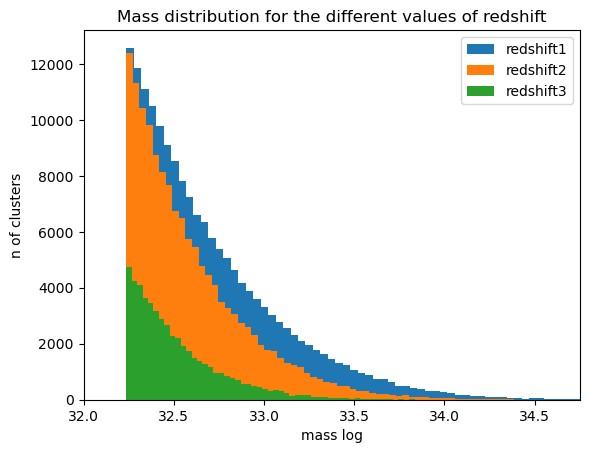

In [39]:
for redshift_value, group in groups.items():
    n_cluster = len(group)
    plt.hist(np.log(group['mass']), bins=75, alpha=1, label=f'{redshift_value}')

plt.xlabel('mass log')
plt.ylabel('n of clusters')
plt.title('Mass distribution for the different values of redshift')
plt.legend()
plt.xlim(32, 34.75)
plt.show()

Da questo primo grafico si osserva che la distribuzione delle masse ha un andamento simile all'interno dei tre gruppi di redshift; grazie a questa analogia è possibile compiere predizioni teoriche sulla distribuzione degli aloni di massa attraverso la stessa funzione per tutti e tre i gruppi di redshift.

<span style="text-decoration:underline;">**Parte 2**

A questo punto si analizzano separatamente i tre gruppi di redshift. Per farlo, si confrontano gli istogrammi ottenuti nella parte 1 con la predizione teorica basata su diversi parametri cosmologici.

Per prima cosa, si importa la libreria _colossus_ e si inroduce la _Halo Mass Function_  (HMF) che permette di calcolare la densità di aloni di materia oscura osservati a partire dai seguenti parametri cosmologici:

$Om0=67.77,$   $Om0=0.31,$   $Ob0=0.31,$   $sigma8=0.81,$   $ns=0.96$

Si plottano quindi le _HMF_ relative ai tre gruppi di redshift.

In [40]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function

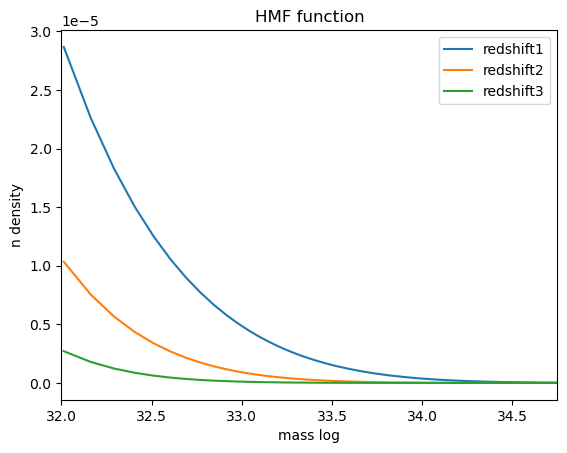

In [71]:
params = {'flat': True, 'H0': 67.77, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.96}
cosmology.addCosmology('myCosmo', params) 
cosmo = cosmology.setCosmology('myCosmo')
mass=np.linspace(8e+13, 2e+15, 150)

for redshift_value, group in groups.items():
    x = group['z'].max()
    v = group['vol'].max()
    mfunc = mass_function.massFunction(mass, x, mdef='vir', model='despali16', q_out='dndlnM')
    plt.plot(np.log(mass), mfunc, label=redshift_value)
    
plt.xlabel('mass log')   
plt.ylabel('n density')   
plt.title('HMF function')
plt.legend()
plt.xlim(32, 34.75)
plt.show()

Viene confrontata ora la distribuzione teorica di massa, predetta dai parametri cosmologici, con quella ricavata dall'analisi grafica del catalogo di ammassi.

Per questo primo confronto grafico si utilizzano gli stessi valori dei parametri per tutti i gruppi di redshift per scoprire se le predizioni teoriche fatte sono compatibili con tutti i tipi di ammassi di galassie.

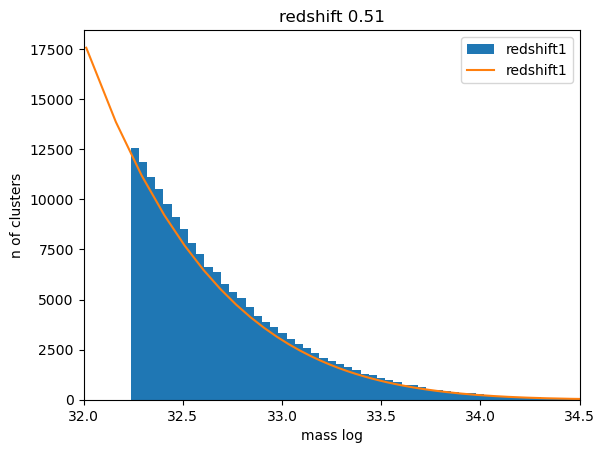

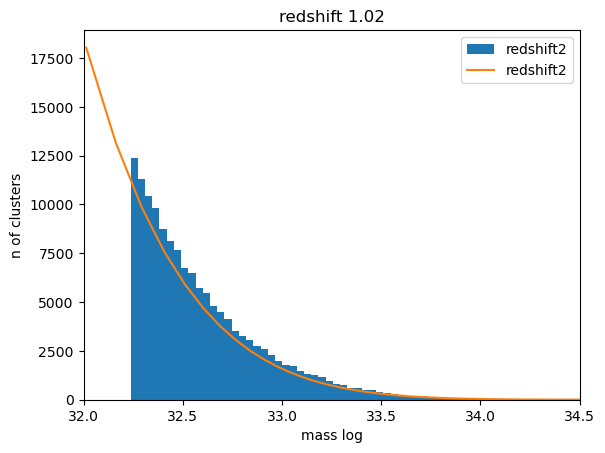

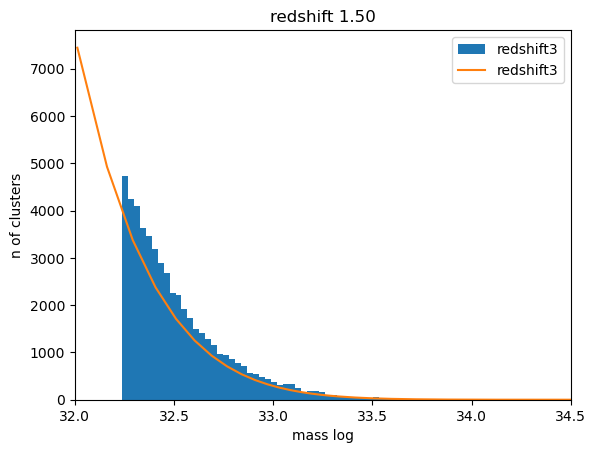

In [42]:
for redshift_value, group in groups.items():
    
    plt.hist(np.log(group['mass']), bins=75, alpha=1, label=redshift_value) 
    width = (np.log(group['mass'].max()) - np.log(group['mass'].min())) / 75
    
    mass = np.linspace(8e+13, 2e+15, 150)
    x = group['z'].max()
    v = group['vol'].max()
    mfunc = mass_function.massFunction(mass, x, mdef='vir', model='despali16', q_out='dndlnM')
    
    n = mfunc * v * width   
    
    plt.plot(np.log(mass), n, label=redshift_value)
    
    plt.xlabel('mass log')
    plt.ylabel('n of clusters') 
    titolo = "redshift %.2f" % (x)
    plt.title(titolo)
    plt.legend()  
    plt.xlim(32, 34.5)
    plt.show()

Si osserva che la funzione descrive in maniera discreta l'andamento dei tre istogrammi: la distribuzione teorica predetta dai diversi parametri cosmologici (_mfunc_) rappresenta quindi una buona approssimazione della distribuzione osservata delle masse degli ammassi. Nonostante un evidente accordo tra le due forme, sono presenti comunque delle discrepanze tra istogramma e grafico, dovute a una probabile sottostima dei parametri cosmologici fissati inizialmente. 

Siccome la discrepanza aumenta con l'aumentare del _redshift_, è plausibile supporre che i parametri cosmologici dipendano in qualche modo da quest'ultimo. In questa prima analisi, infatti, essi sono stati mantenuti costanti per tutti e tre i gruppi di _redshift_. Nel prossimo paragrafo verrà fatta un'analisi più approfondita di alcuni di questi parametri, ricavando la loro miglior stima per i tre gruppi in cui è stato suddiviso il catalogo.

<span style="text-decoration:underline;">**Parte 3a**

Si prosegue con lo studio dell'inferenza bayesiana sui parametri cosmologici $sigma8$ e $Om0$, che descrivono rispettivamente la densità di materia e l'ampiezza delle fluttuazioni della materia su scala di $8\frac{Mpc}{h}$. Per il resto del processo, gli altri parametri vengono fissati ai valori attribuiti inizialmente. Per ipotesi assumo priori piatti per i due parametri $sigma8$ e $Om0$, ovvero appartenenti all'intervallo $[0.1,1.1]$. Sempre per ipotesi, per studiare l'inferenza bayesiana, si assume che il numero di oggetti osservato in un determinato bin di massa (n_obs) sia una realizzazione poissoniana del numero teorico atteso predetto dalla _HMF_ (n_exp).

Il valore di aspettazione per ogni intervallo dell'istogramma sarà dato dalla seguente formula:

$\mu=mfunc*v*width$

in cui $\mu=n_{exp}$, $width$ è la larghezza di ogni intervallo, $v$ il rispettivo volume di universo e $mfunc$ è il valore acquisito dalla funzione di distribuzione teorica per ogni valore di massa.

E' quindi possibile definire il logaritmo della funzione del _Likelihood_ atrraverso il seguente algoritmo.

In [43]:
def log_prior(theta):
    sigma8, Om0 = theta
    if 0.1 <= sigma8 <= 1.1 and 0.1 <= Om0 <= 1.1:
        return 0.0
    return -np.inf

def log_likelihood(theta, group):
    sigma8, Om0 = theta
    params = {'flat': True, 'H0': 67.77, 'Om0': Om0, 'Ob0': 0.049, 'sigma8': sigma8, 'ns': 0.95}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    
    counts, bin_edges = np.histogram(np.log(group['mass']), bins=75)
    width = (np.log(group['mass'].max()) - np.log(group['mass'].min())) / 75
    x = group['z'].max()
    v = group['vol'].max()
    mass = np.exp(bin_edges)[:-1] 
    n_obs = counts
    
    mfunc = mass_function.massFunction(mass, x, mdef='vir', model='despali16', q_out='dndlnM')
    n_exp = mfunc * v * width 
    
    #log_l = np.log(n_exp**n_obs * np.exp(-n_exp))
    #total_log_likelihood = np.nansum(log_l)
    #return total_log_likelihood
     
    l = poisson.pmf(n_obs, n_exp)
    np.where(l < 1e-10, 1e-10, l)
    log_l = np.log(l) 
    total_log_likelihood = np.nansum(log_l)
    return total_log_likelihood

def log_posterior(theta, group):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, group)

Inizialmente ho provato a utilizzare la funzione di distribuzione di Poisson nella forma

$P_{\lambda}(n)=\frac{\lambda^n}{n!}e^{-\lambda}$

in cui $\lambda=n_{exp}$ è il valore di aspettazione predetto dalla teoria per ogni intervallo dell'istogramma e $n=n_{obs}$ è il numero effettivo di ammassi catalogati in ogni intervallo dell'istogramma. Questa però non permetteva al programma di funzionare nel modo corretto in quanto, a causa del gran numero di valori in ogni intervallo dell'istogramma, il fattoriale presente nella funzione di distribuzione richiedeva molto tempo per essere computato. Inoltre, l'algoritmo della Markov chain restituiva stime dei parametri molto lontane dai valori attesi: questo errore potrebbe essere collegato al malfunzionamento citato precedentemente.

Per questo motivo, ho deciso di utilizzare la funzione $poisson.pmf$, imponendo il comando

$np.where(l < 10^{-10}, 10^{-10}, l)$

in modo da evitare di computare il logaritmo naturale di 0 all'interno della $loglikelihood$.

In seguito si applica la funzione di minimizzazione al logaritmo della _posterior_ e si estraggono i migliori valori dei parametri.

In [ ]:
np.random.seed(41)
nll = lambda *args: -log_posterior(*args)
best_fit = {}

initial = np.array([0.81, 0.31])


for redshift_value, group in groups.items():
    args=(group,)
    soln = minimize(nll, initial, args=args)
    sigma8_bf, Om0_bf = soln.x    
    
    best_fit[redshift_value] = soln.x

Attraverso l'algoritmo _emcee_ genero un campione Monte Carlo che segua la distribuzione dei parametri che si vogliono stimare. Eseguo quindi lo stesso procedimento per tutti i tre valori di _redshift_ individuati, ricavando la miglior stima dei parametri e compiendo quindi nuovamente il fit tra distribuzione attesa e distribuzione effettiva.

100%|██████████| 2000/2000 [27:37<00:00,  1.21it/s]


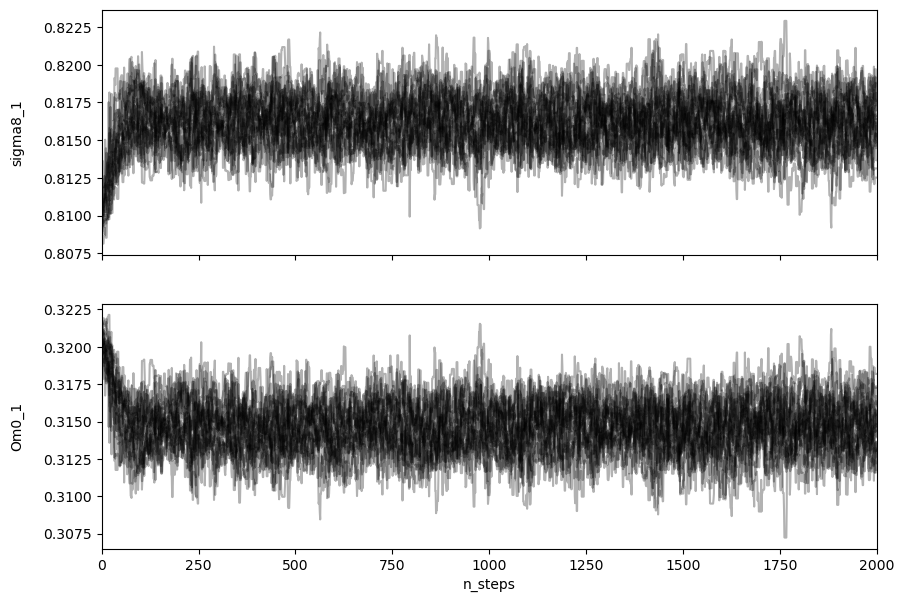

In [45]:
group = groups['redshift1']

pos = best_fit['redshift1'] + 1e-3 * np.random.randn(20, 2)   
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=(group,))
sampler.run_mcmc(pos, 2000, progress=True)    

fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sigma8_1", "Om0_1"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("n_steps")

flat_samples_1 = sampler.get_chain(discard=100, flat=True)

Le migliori stime dei parametri $sigma8$ e $Om0$  per il primo valore di redshift sono quindi la media di tutti i valori dei parametri ottenuti dalla Markov chain. Vengono elencati in seguito con le relative deviazioni standard.

In [46]:
group = groups['redshift1']
print(f'Average Sigma8: {np.mean(flat_samples_1[:,0])}')
print(f'Standard deviation Sigma8: {np.std(flat_samples_1[:,0])}')
print(f'Average Om0: {np.mean(flat_samples_1[:,1])}')
print(f'Standard deviation Om0: {np.std(flat_samples_1[:,1])}')

Average Sigma8: 0.8162390693060518
Standard deviation Sigma8: 0.0016850852195492139
Average Om0: 0.314584997500997
Standard deviation Om0: 0.0016914002597532831


 Osservo che essi sono compatibili con i parametri iniziali utilizzati nell'analisi della parte 2, infatti risulta per entrambi che:

 $sigma8_{in} - 3\sigma_{sigma8} < sigma8_{sim} < sigma8_{in} + 3\sigma_{sigma8}$

 $Om0_{in} - 3\sigma_{Om0} < Om0_{sim} < Om0_{in} + 3\sigma_{Om0}$

 In cui $in$ sta per iniziale e $sim$ sta per simulato.

 Rappresento ora il confronto tra istogramma e funzione di distribuzione teorica della massa (con i nuovi parametri stimati) per vedere se i parametri selezionati approssimano meglio la distribuzione degli ammassi con redshift 0.506.

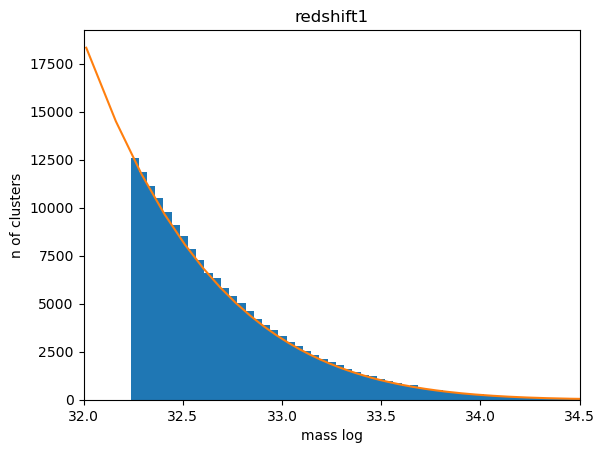

In [47]:
group = groups['redshift1']

params = {'flat': True, 'H0': 67.77, 'Om0': np.mean(flat_samples_1[:,0]), 'Ob0': 0.049, 'sigma8': np.mean(flat_samples_1[:,1]), 'ns': 0.96}
plt.hist(np.log(group['mass']), bins=75, alpha=1, label=redshift_value) 
width = (np.log(group['mass'].max()) - np.log(group['mass'].min())) / 75
    
mass = np.linspace(8e+13, 2e+15, 150)
x = group['z'].max()
v = group['vol'].max()
mfunc = mass_function.massFunction(mass, x, mdef='vir', model='despali16', q_out='dndlnM')
    
n = mfunc * v * width   
    
plt.plot(np.log(mass), n)

plt.xlabel('mass log')
plt.ylabel('n of clusters') 
titolo = "redshift1"
plt.title(titolo) 
plt.xlim(32, 34.5)
plt.show()

Si può osservare immediatamente un miglior accordo tra le due distribuzioni ed è possibile quindi concludere che i parametri cosmologici stimati descrivono in maniera più verosimile quanto ricavato dal campione di ammassi di galassie con redshift 0.51.

Procedo ora analizzando la correlazione che intercorre tra i due parametri $sigma8$ e $Om0$ attraverso la libreria pygtc. Plotto quindi la posterior distribution proiettata sullo spazio dei due parametri. Il grafico in basso a sinistra fornisce la correlazione tra i due parametri.

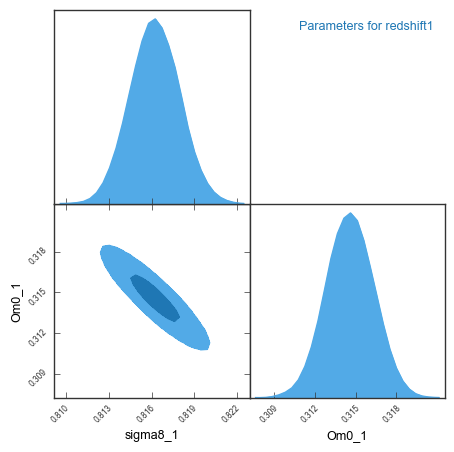

In [48]:
GTC = pygtc.plotGTC(chains=flat_samples_1,
                        paramNames=['sigma8_1','Om0_1'],
                        chainLabels=[f'Parameters for redshift1'],
                        figureSize='MNRAS_page')

Osservo che l'ellisse che si ottiene ha coefficiente angolare negativo e si può affermare che è presente una correlazione inversa tra i due parametri: per un grande valore di uno dei due corrisponde uno più piccolo dell'altro.

I parametri che appartengono alla zona più scura sono quelli che sono stati campionati più volte nell'algoritmo _emcee_ e sono quelli più vicini al picco delle distribuzioni dei due parametri $sigma8$ e $Om0$, mostrati rispettivamente sopra e a destra.
Queste stime di parametri sono quelle che meglio descrivono la distribuzione di ammassi osservata.

Ripeto ora lo stesso processo con il gruppo di ammassi caratterizzati da redshift 1.01 e 1.500. Fornisco alla fine dei due processi un commento sui dati ottenuti.

100%|██████████| 2000/2000 [27:05<00:00,  1.23it/s]


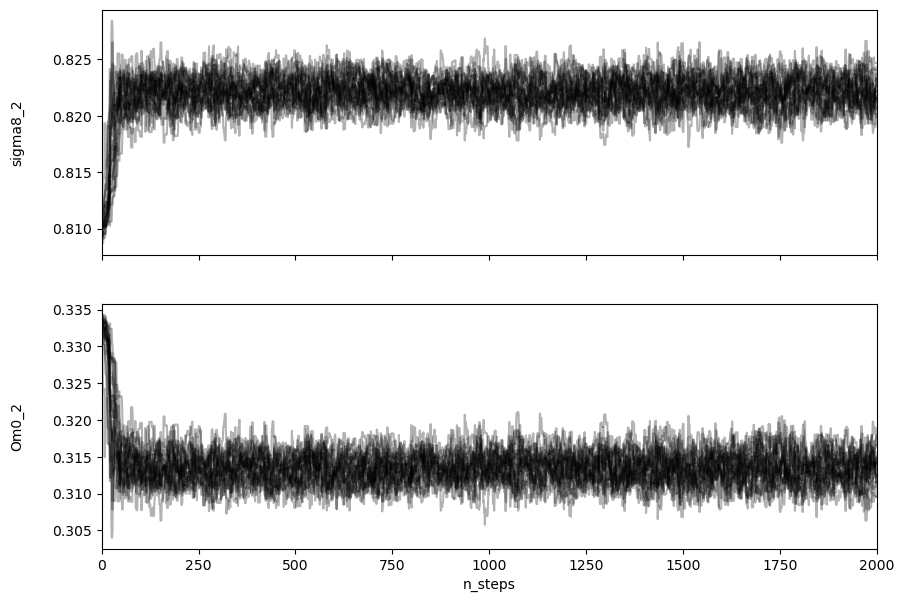

In [49]:
group = groups['redshift2']

pos = best_fit['redshift2'] + 1e-3 * np.random.randn(20, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=(group,))
sampler.run_mcmc(pos, 2000, progress=True)

fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sigma8_2", "Om0_2"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("n_steps")

flat_samples_2 = sampler.get_chain(discard=100, flat=True)

In [50]:
print(f'Average Sigma8: {np.mean(flat_samples_2[:,0])}')
print(f'Standard deviation Sigma8: {np.std(flat_samples_2[:,0])}')
print(f'Average Om0: {np.mean(flat_samples_2[:,1])}')
print(f'Standard deviation Om0: {np.std(flat_samples_2[:,1])}')

Average Sigma8: 0.8221218454609196
Standard deviation Sigma8: 0.001319810787199559
Average Om0: 0.31339180595576394
Standard deviation Om0: 0.00209570134841174


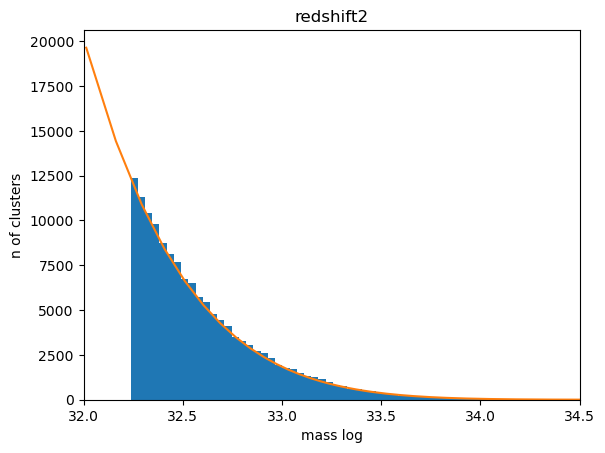

In [51]:
params = {'flat': True, 'H0': 67.77, 'Om0': np.mean(flat_samples_2[:,1]), 'Ob0': 0.049, 'sigma8': np.mean(flat_samples_2[:,0]), 'ns': 0.96}
plt.hist(np.log(group['mass']), bins=75, alpha=1, label=redshift_value) 
width = (np.log(group['mass'].max()) - np.log(group['mass'].min())) / 75
    
mass = np.linspace(8e+13, 2e+15, 150)
x = group['z'].max()
v = group['vol'].max()
mfunc = mass_function.massFunction(mass, x, mdef='vir', model='despali16', q_out='dndlnM')
    
n = mfunc * v * width   
    
plt.plot(np.log(mass), n)

plt.xlabel('mass log')
plt.ylabel('n of clusters') 
titolo = "redshift2"
plt.title(titolo) 
plt.xlim(32, 34.5)
plt.show()

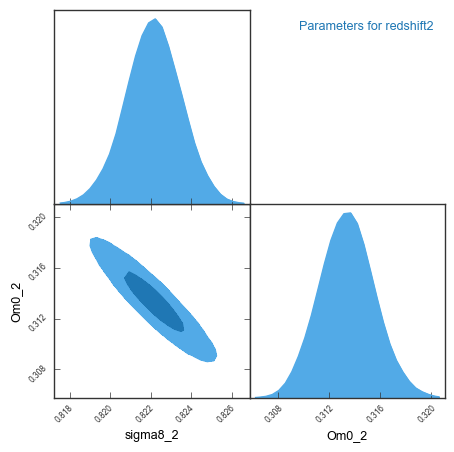

In [52]:
GTC = pygtc.plotGTC(chains=flat_samples_2,
                        paramNames=['sigma8_2','Om0_2'],
                        chainLabels=[f'Parameters for redshift2'],
                        figureSize='MNRAS_page')

100%|██████████| 2000/2000 [26:40<00:00,  1.25it/s]


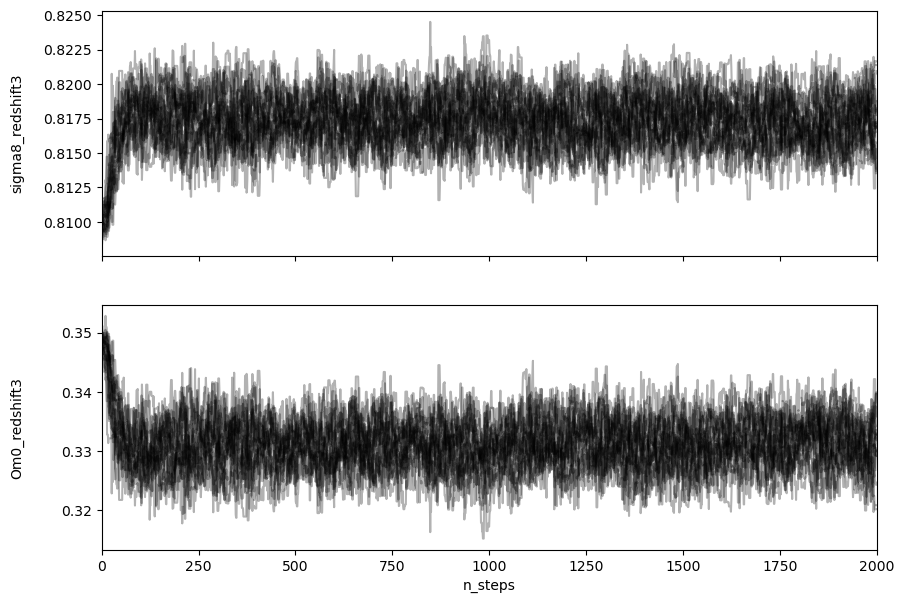

In [53]:
group = groups['redshift3']

pos = best_fit['redshift3'] + 1e-3 * np.random.randn(20, 2)  
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=(group,))
sampler.run_mcmc(pos, 2000, progress=True)   

fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sigma8_redshift3", "Om0_redshift3"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("n_steps")

flat_samples_3 = sampler.get_chain(discard=100, flat=True)

In [54]:
print(f'Average Sigma8: {np.mean(flat_samples_3[:,0])}')
print(f'Standard deviation Sigma8: {np.std(flat_samples_3[:,0])}')
print(f'Average Om0: {np.mean(flat_samples_3[:,1])}')
print(f'Standard deviation Om0: {np.std(flat_samples_3[:,1])}')
print()

Average Sigma8: 0.8174021614456684
Standard deviation Sigma8: 0.001766829507504044
Average Om0: 0.33099706806508405
Standard deviation Om0: 0.004096192246472951



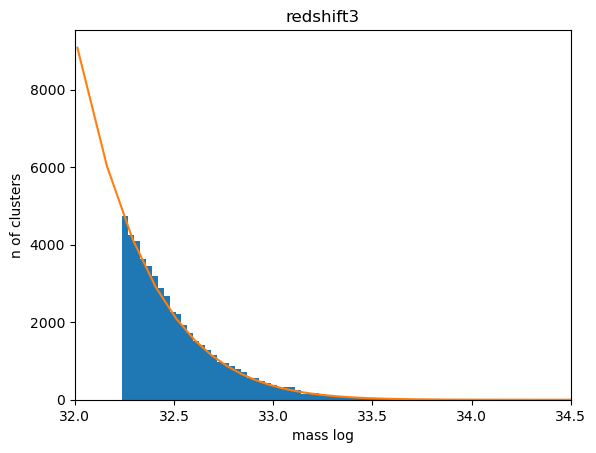

In [55]:
params = {'flat': True, 'H0': 67.77, 'Om0': np.mean(flat_samples_3[:,1]), 'Ob0': 0.049, 'sigma8': np.mean(flat_samples_3[:,0]), 'ns': 0.96}
plt.hist(np.log(group['mass']), bins=75, alpha=1, label=redshift_value) 
width = (np.log(group['mass'].max()) - np.log(group['mass'].min())) / 75
    
mass = np.linspace(8e+13, 2e+15, 150)
x = group['z'].max()
v = group['vol'].max()
mfunc = mass_function.massFunction(mass, x, mdef='vir', model='despali16', q_out='dndlnM')
    
n = mfunc * v * width   
    
plt.plot(np.log(mass), n)

plt.xlabel('mass log')
plt.ylabel('n of clusters') 
titolo = "redshift3"
plt.title(titolo) 
plt.xlim(32, 34.5)
plt.show()

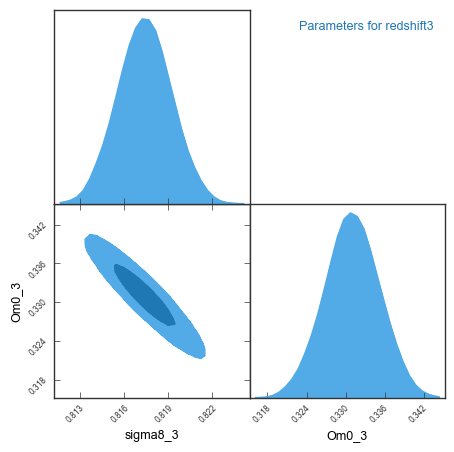

In [56]:
GTC = pygtc.plotGTC(chains=flat_samples_3,
                        paramNames=['sigma8_3','Om0_3'],
                        chainLabels=[f'Parameters for redshift3'],
                        figureSize='MNRAS_page')

Come per il gruppo di ammassi con redshift=0.506, i parametri stimati dall'algoritmo _emcee_ per gli altri due gruppi di redshift sono compatibili con quelli utilizzati nella parte due del programma, sempre per il seguente motivo:

 $sigma8_{in} - 3\sigma_{sigma8} < sigma8_{sim} < sigma8_{in} + 3\sigma_{sigma8}$

 $Om0_{in} - 3\sigma_{Om0} < Om0_{sim} < Om0_{in} + 3\sigma_{Om0}$.

 Si può osservare in entrambi i casi che la _HMF_ dotata dei nuovi parametri stimati descrive in maniera molto più accurata la distribuzione delle masse degli ammassi del catalogo preso in esame.

 La correlazione dei parametri per gli ammassi di redshift 1.01 e 1.500 è inversa, come nel caso del gruppo di redshift=0.506 ed è possibile fare le stesse considerazioni a riguardo del grafico della distribuzione della posterior.

L'analisi è stata svolta considerando separatamente i tre gruppi di redshift, per ottenere delle stime accurate dei parametri cosmologici in funzione di esso e per poter interpolare al meglio i grafici delle distribuzioni degli ammassi. Questo però non esclude che uno studio congiunto avrebbe potuto dare altrettanti risultati utili, come ad esempio eventuali correlazioni tra i valori di redshift e un possibile andamento di $Om0$ e $sigma8$, qualora si andassero a trattare altri valori di redshift non considerati in questa analisi.


In conclusione, ritengo che possa avere senso un'analisi congiunta dei dati per ottenere informazioni "universali" sull'andamento dei vari parametri stimati, senza fare distinzioni tra le categorie di redshift.  

<span style="text-decoration:underline;">**Parte 3b**

Concludo quest'analisi sui parametri cosmologici che governano l'universo trattando l'inferenza bayesiana sui parametri $Ode0$, $Om0$ e $sigma8$. Il parametro $Ode0$ descrive la densità di energia oscura presente nell'universo.

Un universo piatto prevede che $Ode0+Om0+radiazione=1$ (la radiazione al giorno d'oggi risulta trascurabile rispetto agli altri due parametri), mentre nel caso di un universo curvo si introduce il parametro $\Omega_k=1-Ode0-Om0$ il quale descrive la curvatura dell'universo.

Da esperimenti precedenti è possibile vincolare la distribuzione del parametro $Ode0$ ad una distribuzione gaussiana con valore di aspettazione $\mu=0.7$ e varianza $\sigma=0.05$. Mi aspetto quindi che il valore di $\Omega_k$ cada in un intorno di 0 con una varianza data dalla propagazione delle varianze di $Ode0$ e $Om0$.

L'inferenza bayesiana verrà compiuta sui 3 parametri sfruttando sempre l'algoritmo _emcee_ e ricavando la loro migliore stima, in modo da far combaciare al meglio la distribuzione predetta dalla teoria con quella ricavata dai dati.

Il procedimento seguito è analogo alla trattazione con due parametri e si riportano dunque i risultati ottenuti con eventuali commenti alla fine dell'algoritmo.

In [57]:
def log_prior(theta):
    sigma8, Om0, Ode0 = theta
    if 0.1 <= sigma8 <= 1.1 and 0.1 <= Om0 <= 1.1 and 0.0 <= Ode0 <= 1.1:
        log_prior_Ode0 = norm.logpdf(Ode0, loc=0.7, scale=0.05)
        return log_prior_Ode0
    return -np.inf


def log_likelihood(theta, group):
    sigma8, Om0, Ode0 = theta
    params = {'flat': False, 'H0': 67.77, 'Ode0': Ode0, 'Om0': Om0, 'Ob0': 0.049, 'sigma8': sigma8, 'ns': 0.96}
    cosmology.addCosmology('myCosmo', params)
    cosmo = cosmology.setCosmology('myCosmo')
    
    counts, bin_edges= np.histogram(np.log(group['mass']), bins=75)
    plt.close()
    width = (np.log(group['mass'].max()) - np.log(group['mass'].min())) / 75
    z = group['z'].max()
    v = group['vol'].max()
    mass = np.exp(bin_edges)[:-1]
    n_obs = counts    

    mfunc = mass_function.massFunction(mass, z, mdef='vir', model='despali16', q_out='dndlnM')
    n_exp = mfunc * v * width 
    
    n_exp = np.where(n_exp == 0, 1e-100, n_exp)
    n_obs = np.where(n_obs == 0, 1e-100, n_obs)
    
    l = poisson.pmf(n_obs, n_exp)
    l = np.where(l < 1e-10, 1e-10, l)
    log_l = np.log(l)
    total_log_likelihood = np.nansum(log_l)
    return total_log_likelihood


def log_posterior(theta, group):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, group)

In [58]:
np.random.seed(41)
nll = lambda *args: -log_posterior(*args)
best_fit = {}

initial = np.array([0.81, 0.31, 0.7])

for redshift_value, group in groups.items():
    
    args=(group,)
    bounds = [(0.1, 1.1), (0.1, 0.99), (0.1, 0.99)]
    soln = minimize(nll, initial, args=args, bounds=bounds)
    sigma8_bf, Om0_bf, Ode0_bf = soln.x    
    
    best_fit[redshift_value] = soln.x  

100%|██████████| 2000/2000 [28:42<00:00,  1.16it/s]


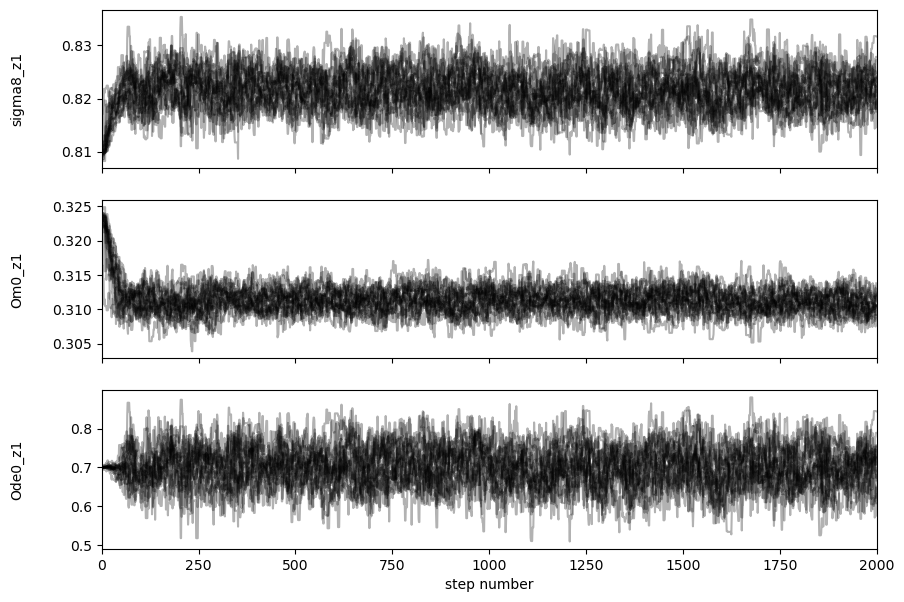

In [59]:
group = groups['redshift1']

pos = best_fit['redshift1'] + 1e-3 * np.random.randn(20, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=(group,))
sampler.run_mcmc(pos, 2000, progress=True)

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sigma8_z1", "Om0_z1", 'Ode0_z1']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
    
flat_samples_4 = sampler.get_chain(discard=100, flat=True)

In [60]:
group = groups['redshift1']
print(f'Average Sigma8: {np.mean(flat_samples_4[:,0])}')
print(f'Standard deviation Sigma8: {np.std(flat_samples_4[:,0])}')
print(f'Average Om0: {np.mean(flat_samples_4[:,1])}')
print(f'Standard deviation Om0: {np.std(flat_samples_4[:,1])}')
print(f'Average Ode0: {np.mean(flat_samples_4[:,2])}')
print(f'Standard deviation Sigma8: {np.std(flat_samples_4[:,2])}')

Average Sigma8: 0.8216926145236083
Standard deviation Sigma8: 0.003538120835808147
Average Om0: 0.31121289320966666
Standard deviation Om0: 0.001652643044639626
Average Ode0: 0.7010890849240164
Standard deviation Sigma8: 0.050340384857870235


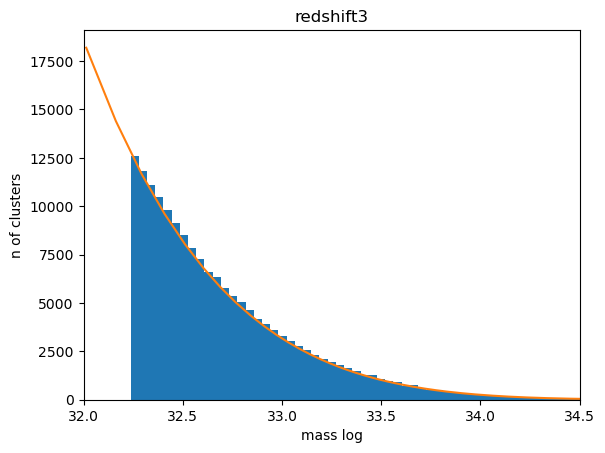

In [61]:
group = groups['redshift1']
params = {'flat': True, 'H0': 67.77, 'Ode0':np.mean(flat_samples_4[:,2]), 'Om0': np.mean(flat_samples_4[:,1]), 'Ob0': 0.049, 'sigma8': np.mean(flat_samples_4[:,0]), 'ns': 0.96}
plt.hist(np.log(group['mass']), bins=75, alpha=1, label=redshift_value) 
width = (np.log(group['mass'].max()) - np.log(group['mass'].min())) / 75
    
mass = np.linspace(8e+13, 2e+15, 150)
x = group['z'].max()
v = group['vol'].max()
mfunc = mass_function.massFunction(mass, x, mdef='vir', model='despali16', q_out='dndlnM')
    
n = mfunc * v * width   
    
plt.plot(np.log(mass), n)

plt.xlabel('mass log')
plt.ylabel('n of clusters') 
titolo = "redshift3"
plt.title(titolo) 
plt.xlim(32, 34.5)
plt.show()

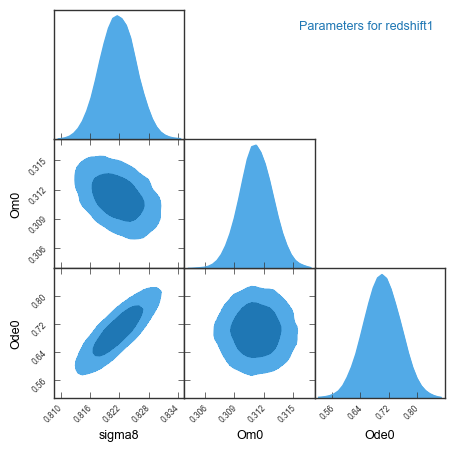

In [62]:
GTC = pygtc.plotGTC(flat_samples_4,
                        paramNames=['sigma8','Om0','Ode0'],
                        chainLabels=[f'Parameters for redshift1'],
                        figureSize='MNRAS_page')

100%|██████████| 2000/2000 [28:13<00:00,  1.18it/s]


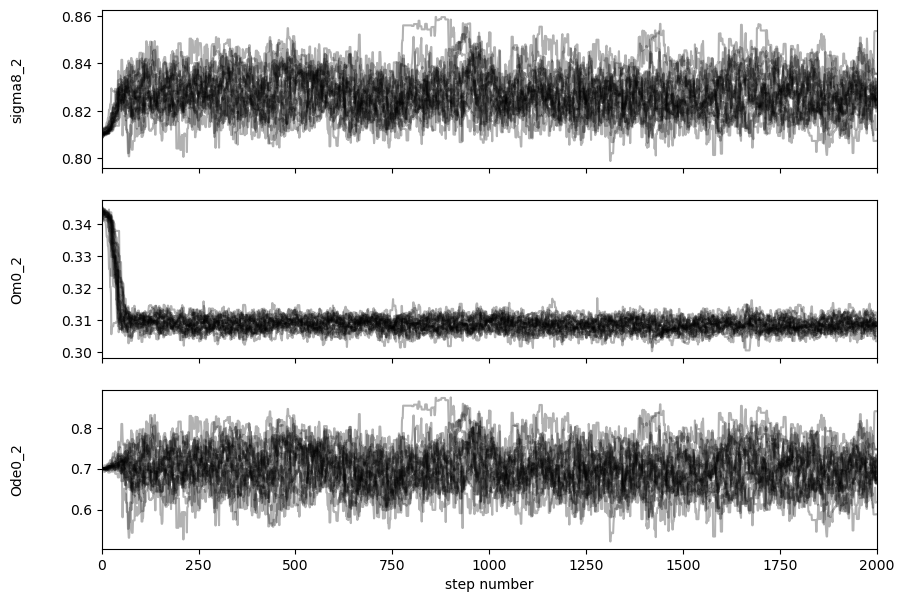

In [63]:
group = groups['redshift2']

pos = best_fit['redshift2'] + 1e-3 * np.random.randn(20, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=(group,))
sampler.run_mcmc(pos, 2000, progress=True)

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sigma8_2", "Om0_2", 'Ode0_2']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
    
flat_samples_5 = sampler.get_chain(discard=100, flat=True)

In [64]:
group = groups['redshift2']
print(f'Average Sigma8: {np.mean(flat_samples_5[:,0])}')
print(f'Standard deviation Sigma8: {np.std(flat_samples_5[:,0])}')
print(f'Average Om0: {np.mean(flat_samples_5[:,1])}')
print(f'Standard deviation Om0: {np.std(flat_samples_5[:,1])}')
print(f'Average Ode0: {np.mean(flat_samples_5[:,2])}')
print(f'Standard deviation Sigma8: {np.std(flat_samples_5[:,2])}')

Average Sigma8: 0.827301469687321
Standard deviation Sigma8: 0.008663369449135278
Average Om0: 0.308594907575443
Standard deviation Om0: 0.0020387676211490314
Average Ode0: 0.7008743903493649
Standard deviation Sigma8: 0.05055847354959245


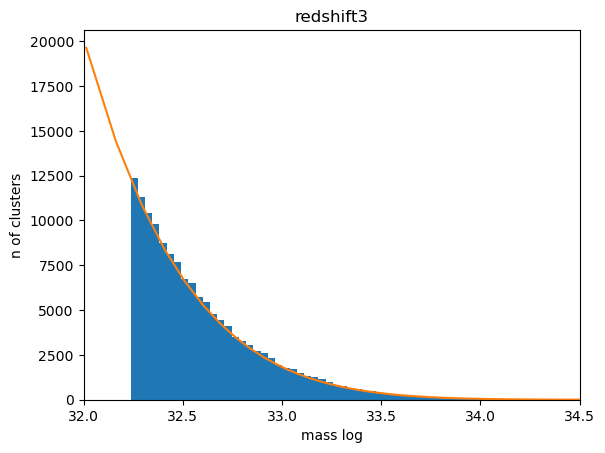

In [65]:
group = groups['redshift2']
params = {'flat': True, 'H0': 67.77, 'Ode0':np.mean(flat_samples_5[:,2]), 'Om0': np.mean(flat_samples_5[:,1]), 'Ob0': 0.049, 'sigma8': np.mean(flat_samples_5[:,0]), 'ns': 0.96}
plt.hist(np.log(group['mass']), bins=75, alpha=1, label=redshift_value) 
width = (np.log(group['mass'].max()) - np.log(group['mass'].min())) / 75
    
mass = np.linspace(8e+13, 2e+15, 150)
x = group['z'].max()
v = group['vol'].max()
mfunc = mass_function.massFunction(mass, x, mdef='vir', model='despali16', q_out='dndlnM')
    
n = mfunc * v * width   
    
plt.plot(np.log(mass), n)

plt.xlabel('mass log')
plt.ylabel('n of clusters') 
titolo = "redshift3"
plt.title(titolo) 
plt.xlim(32, 34.5)
plt.show()

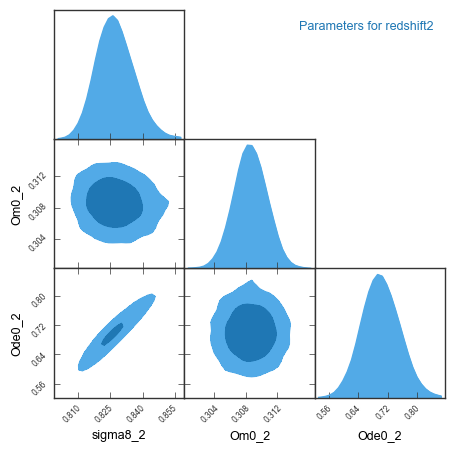

In [66]:
GTC = pygtc.plotGTC(flat_samples_5,
                        paramNames=['sigma8_2','Om0_2','Ode0_2'],
                        chainLabels=[f'Parameters for redshift2'],
                        figureSize='MNRAS_page')

100%|██████████| 2000/2000 [27:23<00:00,  1.22it/s]


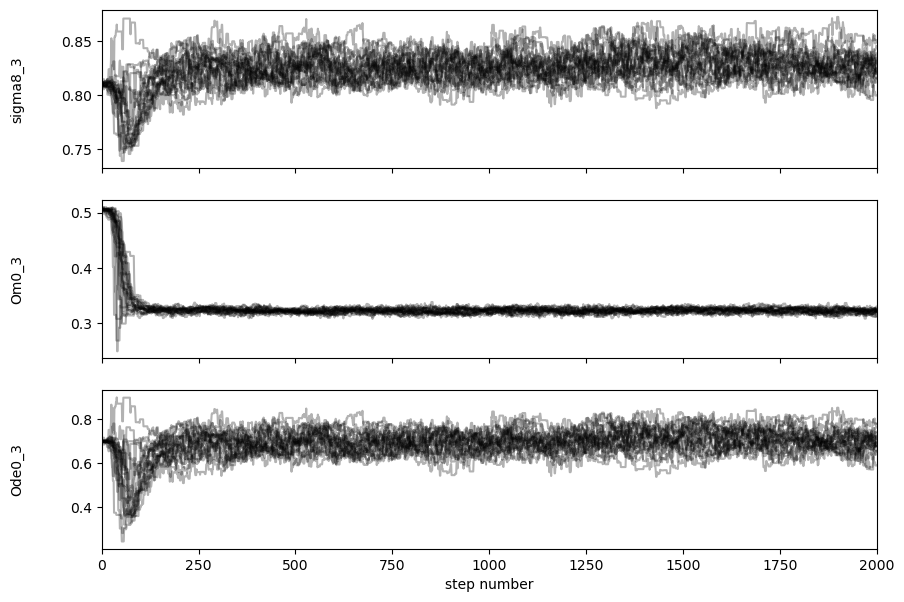

In [67]:
group = groups['redshift3']

pos = best_fit['redshift3'] + 1e-3 * np.random.randn(20, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=(group,))
sampler.run_mcmc(pos, 2000, progress=True)

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sigma8_3", "Om0_3", 'Ode0_3']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
    
flat_samples_6 = sampler.get_chain(discard=100, flat=True)

In [68]:
group = groups['redshift3']
print(f'Average Sigma8: {np.mean(flat_samples_6[:,0])}')
print(f'Standard deviation Sigma8: {np.std(flat_samples_6[:,0])}')
print(f'Average Om0: {np.mean(flat_samples_6[:,1])}')
print(f'Standard deviation Om0: {np.std(flat_samples_6[:,1])}')
print(f'Average Ode0: {np.mean(flat_samples_6[:,2])}')
print(f'Standard deviation Sigma8: {np.std(flat_samples_6[:,2])}')

Average Sigma8: 0.8264953737982257
Standard deviation Sigma8: 0.01370450507297883
Average Om0: 0.3231280460042715
Standard deviation Om0: 0.004289937725553109
Average Ode0: 0.6976635493175397
Standard deviation Sigma8: 0.053081155356152515


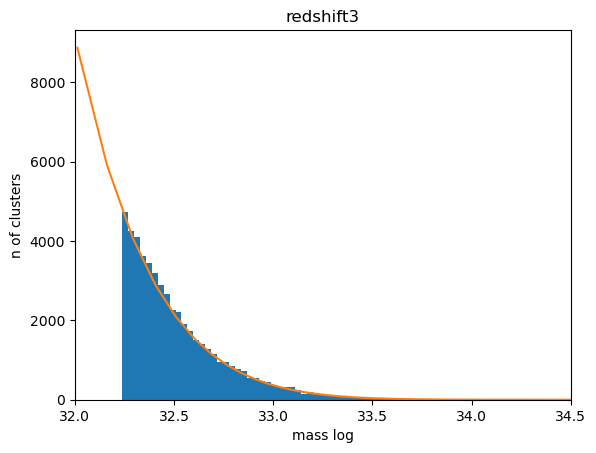

In [69]:
group = groups['redshift3']
params = {'flat': True, 'H0': 67.77, 'Ode0':np.mean(flat_samples_6[:,2]), 'Om0': np.mean(flat_samples_6[:,1]), 'Ob0': 0.049, 'sigma8': np.mean(flat_samples_6[:,0]), 'ns': 0.96}
plt.hist(np.log(group['mass']), bins=75, alpha=1, label=redshift_value) 
width = (np.log(group['mass'].max()) - np.log(group['mass'].min())) / 75
    
mass = np.linspace(8e+13, 2e+15, 150)
x = group['z'].max()
v = group['vol'].max()
mfunc = mass_function.massFunction(mass, x, mdef='vir', model='despali16', q_out='dndlnM')
    
n = mfunc * v * width   
    
plt.plot(np.log(mass), n)

plt.xlabel('mass log')
plt.ylabel('n of clusters') 
titolo = "redshift3"
plt.title(titolo) 
plt.xlim(32, 34.5)
plt.show()

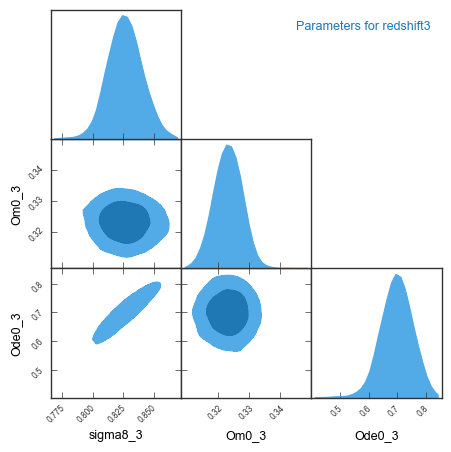

In [70]:
GTC = pygtc.plotGTC(flat_samples_6,
                        paramNames=['sigma8_3','Om0_3','Ode0_3'],
                        chainLabels=[f'Parameters for redshift3'],
                        figureSize='MNRAS_page')

Le considerazioni sul fit grafico dei tre istogrammi della distribuzione delle masse sono le stesse del processo di stima dei soli parametri $Om0$ e $sigma8$: si può affermare che la predizione teorica basata sulla stima dei parametri $Om0$, $Ode0$ e $sigma8$ interpola in maniera accurata tutte le distribuzioni di massa dei tre gruppi di redshift.

Dai grafici _plottati_ con pygtc si osserva che i parametri $Ode0$ e $sigma8$ seguono una correlazione diretta, infatti all'aumentare di uno segue un aumento anche dell'altro. In questo caso, per le coppie di parametri $Ode0$-$Om0$ e $Om0$-$sigma8$ non è possibile stabilire una correlazione e sembrerebbe quasi che tra di essi sussista una correlazione molto debole, dal momento che i grafici congiunti non mostrano un'evidente inclinazione positiva o negativa. 

Come ultimo passaggio di questa trattazione calcolo il valore di $\Omega_k$ per i tre gruppi di redshift, rifacendomi alla formula

$\Omega_k=1-\Omega_m-\Omega_{\Lambda}$

In cui $\Omega_m=Om0$ e $\Omega_{\Lambda}=Ode0$

Calcolo ora il valore di $\Omega_k$ per i tre valori di redshift, fornendone un andamento a partire dai valori dei parametri simulati precedentemente.

omega_k: -0.012301978133682964
dev std omega_k: 0.05036458319042955



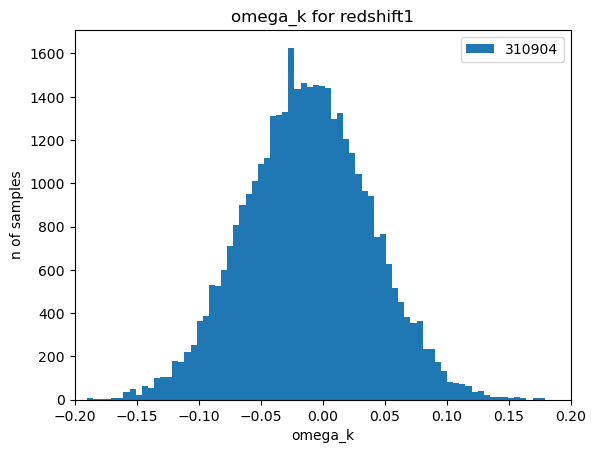

In [89]:
omega_k = 1 - flat_samples_4[:,1] - flat_samples_4[:,2]
print(f'omega_k: {np.mean(omega_k)}')
print(f'dev std omega_k: {np.std(omega_k)}')
print()
plt.hist(omega_k, bins=75, alpha=1, label=redshift_value)
    
plt.xlabel('omega_k')
plt.ylabel('n of samples')
plt.title('omega_k for redshift1')
plt.xlim(-0.2, 0.2)
plt.legend()
plt.show()

omega_k: -0.009469297924808046
dev std omega_k: 0.05058814956587615



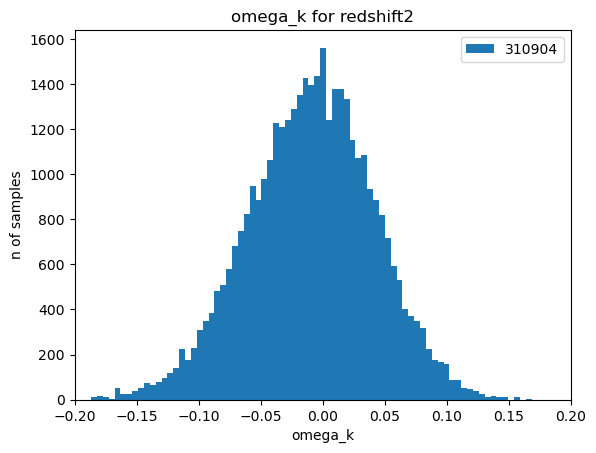

In [91]:
omega_k = 1 - flat_samples_5[:,1] - flat_samples_5[:,2]
print(f'omega_k: {np.mean(omega_k)}')
print(f'dev std omega_k: {np.std(omega_k)}')
print()
plt.hist(omega_k, bins=75, alpha=1, label=redshift_value)
    
plt.xlabel('omega_k')
plt.ylabel('n of samples')
plt.title('omega_k for redshift2')
plt.xlim(-0.2, 0.2)
plt.legend()
plt.show()

omega_k: -0.020791595321811292
dev std omega_k: 0.05315993274943329



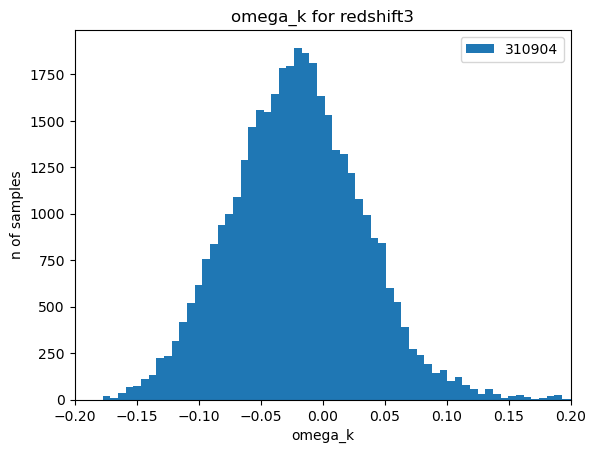

In [92]:
omega_k = 1 - flat_samples_6[:,1] - flat_samples_6[:,2]
print(f'omega_k: {np.mean(omega_k)}')
print(f'dev std omega_k: {np.std(omega_k)}')
print()
plt.hist(omega_k, bins=75, alpha=1, label=redshift_value)
    
plt.xlabel('omega_k')
plt.ylabel('n of samples')
plt.title('omega_k for redshift3')
plt.xlim(-0.2, 0.2)
plt.legend()
plt.show()

Si osserva che in tutti i casi la distribuzione di $\Omega_k$ è centrata in valori prossimi allo 0 (come atteso dall'analisi preliminare) ed è quasi simmetrica rispetto al valore di massimo. Inoltre, i valori del parametro si distribuiscono in maggioranza negli intorni del picco: ciò vuol dire che nella maggior parte delle simulazioni fatte, sono stati ottenuti dei buoni parametri per la descrizione dell'universo studiato da Euclid.

<span style="text-decoration:underline;">**Conclusioni**

Si può concludere che gli ammassi di galassie che verranno osservati dalla missione Euclid potranno essere descritti in maniera fedele dai parametri cosmologici analizzati durante questo elaborato, dal momento che i risultati ottenuti sono apparsi coerenti con quanto atteso dalla predizione teorica. Il processo di stima dei parametri attraverso la Markov chain, inoltre, si è rivelato un mezzo ottimale per estrapolare dei valori che approssimassero al meglio l'andamento delle varie distribuzioni.